In [1]:
%matplotlib widget

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import TqdmExperimentalWarning
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import torch
import matplotlib.patches as patches
import math
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib


# neighborSearch, neighborSearchFixed
# from torchCompactRadius.util import volumeToSupport
# from torchCompactRadius.neighborhood import neighborSearch

In [2]:
import torchCompactRadius as tcr
from torchCompactRadius import neighborSearch
from torchCompactRadius.util import volumeToSupport

In [4]:
import platform
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if platform.system() == 'Darwin':
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cpu')
targetNumNeighbors = 50
hashMapLength = 4096
nx = 32
dim = 2

minDomain = torch.tensor([-1] * dim, dtype = torch.float32, device = device)
maxDomain = torch.tensor([ 1] * dim, dtype = torch.float32, device = device)
maxDomain[0] = 2
periodicity = [True] * dim

extent = maxDomain - minDomain
shortExtent = torch.min(extent, dim = 0)[0].item()
dx = (shortExtent / nx)
ny = int(1 // dx)
h = volumeToSupport(dx**dim, 50, dim)
dy = dx

In [5]:
positions = []
for d in range(dim):
    positions.append(torch.linspace(minDomain[d] + dx / 2, maxDomain[d] - dx / 2, int((extent[d] - dx) / dx) + 1, device = device))
grid = torch.meshgrid(*positions, indexing = 'xy')
positions = torch.stack(grid, dim = -1).reshape(-1,dim).to(device)
# enable for random positions for alternative debugging
# positions = (torch.rand(nx**dim, dim) * 2 - 1).to(device)

supports = torch.ones(positions.shape[0], device = device) * h

In [6]:
xpos2 = torch.linspace(-0.5 + dy / 2, 0.5 - dy / 2, ny)
ypos2 = torch.linspace(-0.5 + dy / 2, 0.5 - dy / 2, ny)
xpos2, ypos2 = torch.meshgrid(xpos2, ypos2, indexing = 'xy')
y = torch.stack((xpos2.flatten(), ypos2.flatten()), dim = 1).to(device)
# y = torch.clone(positions)
ySupport = torch.ones(y.shape[0], device = device) * supports[0]

In [7]:
from torchCompactRadius.util import hashCellIndices_cpp, linearIndexing, hashCellIndices

# indices = torch.floor((positions - (minDomain).to(positions.device)) / hCell).to(torch.int32)
# linearIndices = linearIndexing(indices, numCells) #indices[:,0] + cellCount[0] * indices[:,1]
# cellIndices, cellCounters = torch.unique_consecutive(linearIndices, return_counts=True, return_inverse=False)

# print('indices', indices)

hashedIndices = hashCellIndices(torch.tensor([[0,0], [1,0], [2,0]]), hashMapLength)
print('hashed indices (python | cpu)', hashedIndices.detach().cpu().numpy())

hashed indices (python | cpu) [   0 1117 2234]


In [7]:
# (i_cpu, j_cpu), ni_cpu, nj_cpu, *_ = neighborSearch((positions, y), (supports, ySupport), (minDomain, maxDomain), periodicity, hashMapLength, 'symmetric', 'python')
# (i_cpu, j_cpu), ni_cpu, nj_cpu, *_ = neighborSearch((positions, y), h, (minDomain, maxDomain), periodicity, hashMapLength, 'symmetric', 'python')

# (i_cpu, j_cpu), ni_cpu, nj_cpu, *_ = neighborSearch((positions, y), (supports, ySupport), (minDomain, maxDomain), periodicity, hashMapLength, 'symmetric', 'pythonDynamic')
# (i_cpu, j_cpu), ni_cpu, nj_cpu, *_ = neighborSearch((positions, y), h, (minDomain, maxDomain), periodicity, hashMapLength, 'symmetric', 'pythonDynamic')

In [8]:
# sortedPositions, sortedSupports, hashTable, sortedCellTable, hCell, qMin, qMax, numCells, sortIndex = _

In [9]:
# (i_cpu, j_cpu), ni_cpu, nj_cpu, *_ = tcr.neighborSearch((positions, y), (supports, ySupport), (minDomain, maxDomain), periodicity, hashMapLength, 'symmetric', 'cpp')
# (i_cpu, j_cpu), ni_cpu, nj_cpu, *_ = tcr.neighborSearch((positions, y), h, (minDomain, maxDomain), periodicity, hashMapLength, 'symmetric', 'cpp')
# (i_cpu, j_cpu), ni_cpu, nj_cpu, *_ = tcr.neighborSearch(positions, (supports, supports), (minDomain, maxDomain), periodicity, hashMapLength = hashMapLength, mode = 'symmetric', variant = 'cpp', verbose = False)
# (i_cpu, j_cpu), ni_cpu, nj_cpu, *_ = tcr.neighborSearch(positions, h, (minDomain, maxDomain), periodicity, hashMapLength = hashMapLength, mode = 'symmetric', variant = 'cpp')
# (i_cpu, j_cpu), ni_cpu, nj_cpu, *_ = tcr.neighborSearch(positions, (supports, supports), (minDomain, maxDomain), hashMapLength = hashMapLength, mode = 'symmetric', variant = 'cpp', verbose = False)
# (i_cpu, j_cpu), ni_cpu, nj_cpu, *_ = tcr.neighborSearch(positions, h, (minDomain, maxDomain), hashMapLength = hashMapLength, mode = 'symmetric', variant = 'cpp')
# (i_cpu, j_cpu), ni_cpu, nj_cpu, *_ = tcr.neighborSearch(positions, (supports, supports), hashMapLength = hashMapLength, mode = 'symmetric', variant = 'cpp', verbose = False)
# (i_cpu, j_cpu), ni_cpu, nj_cpu, *_ = tcr.neighborSearch(positions, h, hashMapLength = hashMapLength, mode = 'symmetric', variant = 'cpp')

In [9]:
(i_cpu, j_cpu), ni_cpu, nj_cpu, sortedPositions, sortedSupports, hashTable, sortedCellTable, hCell, qMin, qMax, numCells, sortIndex = \
     neighborSearch((y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength, 'symmetric', 'cpp')

cell[0] = [0, 0] -> hashIndicesAccessor[0] = 0
cell[1] = [1, 0] -> hashIndicesAccessor[1] = 1117
cell[2] = [2, 0] -> hashIndicesAccessor[2] = 2234
cell[3] = [3, 0] -> hashIndicesAccessor[3] = 3351
cell[4] = [4, 0] -> hashIndicesAccessor[4] = 372
cell[5] = [5, 0] -> hashIndicesAccessor[5] = 1489
cell[6] = [6, 0] -> hashIndicesAccessor[6] = 2606
cell[7] = [7, 0] -> hashIndicesAccessor[7] = 3723
cell[8] = [8, 0] -> hashIndicesAccessor[8] = 744
cell[9] = [9, 0] -> hashIndicesAccessor[9] = 1861
cell[10] = [10, 0] -> hashIndicesAccessor[10] = 2978
cell[11] = [11, 0] -> hashIndicesAccessor[11] = 4095
cell[12] = [0, 1] -> hashIndicesAccessor[12] = 159
cell[13] = [1, 1] -> hashIndicesAccessor[13] = 1276
cell[14] = [2, 1] -> hashIndicesAccessor[14] = 2393
cell[15] = [3, 1] -> hashIndicesAccessor[15] = 3510
cell[16] = [4, 1] -> hashIndicesAccessor[16] = 531
cell[17] = [5, 1] -> hashIndicesAccessor[17] = 1648
cell[18] = [6, 1] -> hashIndicesAccessor[18] = 2765
cell[19] = [7, 1] -> hashIndicesAcces

In [11]:
print('i_cpu', i_cpu.device, i_cpu.dtype, i_cpu.shape, i_cpu)
print('j_cpu', j_cpu.device, j_cpu.dtype, j_cpu.shape, j_cpu)
print('ni_cpu', ni_cpu.device, ni_cpu.dtype, ni_cpu.shape, ni_cpu)
print('nj_cpu', nj_cpu.device, nj_cpu.dtype, nj_cpu.shape, nj_cpu)
print('sortedPositions', sortedPositions.device, sortedPositions.dtype, sortedPositions.shape, sortedPositions)
print('sortedSupports', sortedSupports.device, sortedSupports.dtype, sortedSupports.shape, sortedSupports)
print('hashTable', hashTable.device, hashTable.dtype, hashTable.shape, hashTable)
print('sortedCellTable', sortedCellTable.device, sortedCellTable.dtype, sortedCellTable.shape, sortedCellTable)
print('qMin', qMin.device, qMin.dtype, qMin.shape, qMin)
print('qMax', qMax.device, qMax.dtype, qMax.shape, qMax)
print('numCells', numCells.device, numCells.dtype, numCells.shape, numCells)
print('sortIndex', sortIndex.device, sortIndex.dtype, sortIndex.shape, sortIndex)


i_cpu cpu torch.int64 torch.Size([0]) tensor([], dtype=torch.int64)
j_cpu cpu torch.int64 torch.Size([0]) tensor([], dtype=torch.int64)
ni_cpu cpu torch.int64 torch.Size([256]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 

In [11]:
# (i_cpu, j_cpu), ni_cpu, nj_cpu, sortedPositions, sortedSupports, hashTable, sortedCellTable, hCell, qMin, qMax, numCells, sortIndex = \
#     neighborSearch_cpp(y, ySupport, positions, supports, minDomain, maxDomain, periodicity, hashMapLength = hashMapLength)

# (i_cpu, j_cpu), ni_cpu, nj_cpu, sortedPositions, hashTable, sortedCellTable, hCell, qMin, qMax, numCells, sortIndex = \
#     neighborSearchFixed_cpp(y, positions, h, minDomain, maxDomain, periodicity, hashMapLength = hashMapLength)

# (i_cpu, j_cpu), ni_cpu, nj_cpu, sortedPositions, sortedSupports, hashTable, sortedCellTable, hCell, qMin, qMax, numCells, sortIndex = \
#     neighborSearch(y, ySupport, positions, supports, minDomain, maxDomain, periodicity, hashMapLength = hashMapLength)

# (i_cpu, j_cpu), ni_cpu, nj_cpu, sortedPositions, hashTable, sortedCellTable, hCell, qMin, qMax, numCells, sortIndex = \
    # neighborSearchFixed(y, positions, h, minDomain, maxDomain, periodicity, hashMapLength = hashMapLength)

# (i_cpu, j_cpu), ni_cpu, nj_cpu, sortedPositions, sortedSupports, hashTable, sortedCellTable, hCell, qMin, qMax, numCells, sortIndex = \
    # neighborSearchDynamic(y, ySupport, positions, supports, minDomain, maxDomain, periodicity, hashMapLength = hashMapLength)

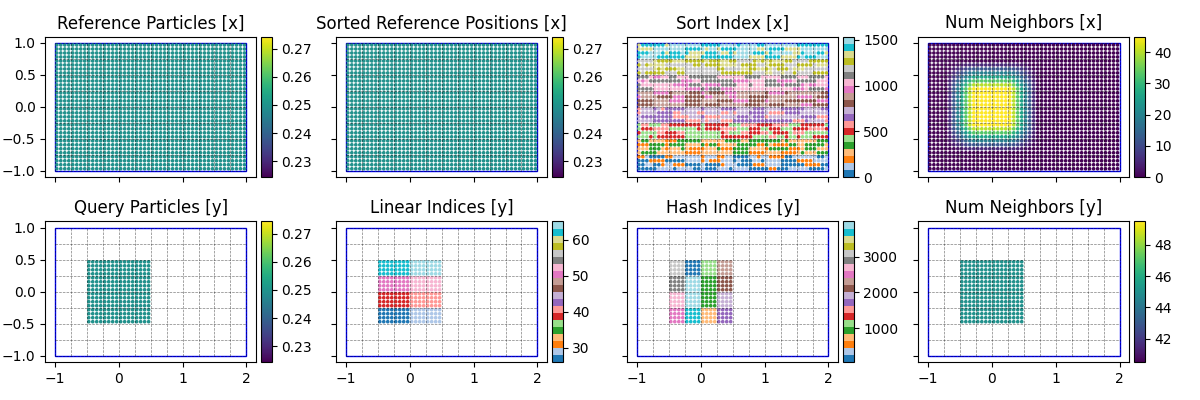

In [12]:
def plotGrid(ax, qMin, qMax, hCell, numCells):
    ax.add_patch(patches.Rectangle((qMin[0].detach().cpu(), qMin[1].detach().cpu()), (qMax[0] - qMin[0]).detach().cpu(), (qMax[1] - qMin[1]).detach().cpu(), fill=False, edgecolor='b', linewidth = 1))
    for i in range(numCells[0].detach().cpu() + 1):
        ax.vlines(x = qMin[0].detach().cpu() + i * hCell, ymin = qMin[1].detach().cpu(), ymax = qMax[1].detach().cpu(), color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)
    for i in range(numCells[1].detach().cpu() + 1): 
        ax.hlines(y = qMin[1].detach().cpu() + i * hCell, xmin = qMin[0].detach().cpu(), xmax = qMax[0].detach().cpu(), color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)
    ax.set_aspect(1, adjustable='box')

def scatterPlot(fig, ax, positions, c, scatterSize, title, cmap = 'viridis', norm = 'linear', midPoint = 0):
    if norm == 'log':
        dataNorm = matplotlib.colors.LogNorm(vmin = c.min(), vmax = c.max())
    elif norm == 'sym':
        dataNorm = matplotlib.colors.Normalize(vmin = midPoint - (midPoint - c).abs().max(), vmax = midPoint + (midPoint - c).abs().max())
    else:
        dataNorm = matplotlib.colors.Normalize(vmin = c.min(), vmax = c.max())

    sc = ax.scatter(positions[:,0].detach().cpu(), positions[:,1].detach().cpu(), c = c.detach().cpu(), s = scatterSize, label = title, cmap = cmap, norm = dataNorm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)    
    plt.colorbar(sc, cax=cax)
    ax.set_title(title)


fig, axis = plt.subplots(2, 4, figsize=(12,4), sharex = True, sharey = True, squeeze = False)

for ax in axis.flatten():
    plotGrid(ax, qMin, qMax, hCell, numCells)
scatterSize = 100 / math.sqrt(positions.shape[0])

scatterPlot(fig, axis[0,0], positions, supports, scatterSize, 'Reference Particles [x]')
scatterPlot(fig, axis[0,1], sortedPositions, sortedSupports, scatterSize, 'Sorted Reference Positions [x]')
scatterPlot(fig, axis[1,0], y, ySupport, scatterSize, 'Query Particles [y]')

scatterPlot(fig, axis[0,2], positions, sortIndex, scatterSize, 'Sort Index [x]', cmap = 'tab20', norm = 'linear')

from torchCompactRadius.util import linearIndexing, hashCellIndices

cellIndices = torch.floor((y - qMin) / hCell).to(torch.int32)
linearIndices = linearIndexing(cellIndices, numCells)
hashIndices = hashCellIndices(cellIndices, hashMapLength)
scatterPlot(fig, axis[1,1], y, linearIndices, scatterSize, 'Linear Indices [y]', cmap = 'tab20', norm = 'linear')
scatterPlot(fig, axis[1,2], y, hashIndices, scatterSize, 'Hash Indices [y]', cmap = 'tab20', norm = 'linear')

scatterPlot(fig, axis[0,3], positions, nj_cpu, scatterSize, 'Num Neighbors [x]')
scatterPlot(fig, axis[1,3], y, ni_cpu, scatterSize, 'Num Neighbors [y]')

fig.tight_layout()

In [11]:
from torchCompactRadius.util import hashCellIndices_cpp, linearIndexing, hashCellIndices

indices = torch.floor((positions - (minDomain).to(positions.device)) / hCell).to(torch.int32)
linearIndices = linearIndexing(indices, numCells) #indices[:,0] + cellCount[0] * indices[:,1]
cellIndices, cellCounters = torch.unique_consecutive(linearIndices, return_counts=True, return_inverse=False)

print('indices', indices[:16,:])

# hashedIndices = hashCellIndices(indices, hashMapLength)
# print('hashed indices (python | cpu)', hashedIndices.detach().cpu().numpy())
hashedIndices = hashCellIndices_cpp(indices[:16,:], hashMapLength)
print('hashed indices (C++ | cpu)', hashedIndices.detach().cpu().numpy())

# hashedIndices = hashCellIndices(indices.to('cuda'), hashMapLength)
# print('hashed indices (python | gpu)', hashedIndices.detach().cpu().numpy())
# hashedIndices = hashCellIndices_cpp(indices.to('cuda'), hashMapLength)
# print('hashed indices (C++ | gpu)', hashedIndices.detach().cpu().numpy())

In [12]:
hashedCellIndices = hashCellIndices_cpp(indices, hashMapLength)
for i in range(len(indices)):
    print('cell', i, 'linear index', indices[i], 'hashed index', hashedCellIndices[i])

cell 0 linear index tensor([0, 0], dtype=torch.int32) hashed index tensor(3804, dtype=torch.int32)
cell 1 linear index tensor([0, 0], dtype=torch.int32) hashed index tensor(3804, dtype=torch.int32)
cell 2 linear index tensor([0, 0], dtype=torch.int32) hashed index tensor(3804, dtype=torch.int32)
cell 3 linear index tensor([0, 0], dtype=torch.int32) hashed index tensor(3804, dtype=torch.int32)
cell 4 linear index tensor([1, 0], dtype=torch.int32) hashed index tensor(825, dtype=torch.int32)
cell 5 linear index tensor([1, 0], dtype=torch.int32) hashed index tensor(825, dtype=torch.int32)
cell 6 linear index tensor([1, 0], dtype=torch.int32) hashed index tensor(825, dtype=torch.int32)
cell 7 linear index tensor([1, 0], dtype=torch.int32) hashed index tensor(825, dtype=torch.int32)
cell 8 linear index tensor([2, 0], dtype=torch.int32) hashed index tensor(1942, dtype=torch.int32)
cell 9 linear index tensor([2, 0], dtype=torch.int32) hashed index tensor(1942, dtype=torch.int32)
cell 10 linear

In [31]:
hashedCellIndices = hashCellIndices(indices, hashMapLength)
for i in range(len(indices)):
    print('cell', i, 'linear index', indices[i], 'hashed index', hashedCellIndices[i])

cell 0 linear index tensor([0, 0], dtype=torch.int32) hashed index tensor(0, dtype=torch.int32)
cell 1 linear index tensor([0, 0], dtype=torch.int32) hashed index tensor(0, dtype=torch.int32)
cell 2 linear index tensor([0, 0], dtype=torch.int32) hashed index tensor(0, dtype=torch.int32)
cell 3 linear index tensor([0, 0], dtype=torch.int32) hashed index tensor(0, dtype=torch.int32)
cell 4 linear index tensor([1, 0], dtype=torch.int32) hashed index tensor(1117, dtype=torch.int32)
cell 5 linear index tensor([1, 0], dtype=torch.int32) hashed index tensor(1117, dtype=torch.int32)
cell 6 linear index tensor([1, 0], dtype=torch.int32) hashed index tensor(1117, dtype=torch.int32)
cell 7 linear index tensor([1, 0], dtype=torch.int32) hashed index tensor(1117, dtype=torch.int32)
cell 8 linear index tensor([2, 0], dtype=torch.int32) hashed index tensor(2234, dtype=torch.int32)
cell 9 linear index tensor([2, 0], dtype=torch.int32) hashed index tensor(2234, dtype=torch.int32)
cell 10 linear index t